In [ ]:
!pip install bio
!pip install biopython
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 57.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize


In [ ]:
# Download required resources for NLTK
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Extract data from PubMed

In [ ]:
import Bio
from Bio import Entrez

# Provide email address to NCBI
Entrez.email = "phangyi@graduate.utm.my"

# Define your search terms
terms = ["Type 1 Diabetes Mellitus", "Type 2 Diabetes Mellitus", "Symptom", "Treatment"]
start_year = "2020"
end_year = "2023"

# Combine the search terms using the AND operator
search_term = " AND ".join(terms)

# Search for articles using the combined search term
handle = Entrez.esearch(db="pubmed", term=search_term, retmax=300, mindate=start_year, maxdate=end_year)

# Fetch the list of article IDs
record = Entrez.read(handle)
id_list = record["IdList"]

# Create a list to store the extracted data
data = []

# Create a set to store the processed PMIDs
processed_pmids = set()

for pmid in id_list:
  if pmid in processed_pmids:
    continue

  try:
    handle = Entrez.efetch(db='pubmed', id=pmid, retmode='xml')
    article = Entrez.read(handle)['PubmedArticle'][0]
    handle.close()

    title = article['MedlineCitation']['Article']['ArticleTitle']
    abstract = article['MedlineCitation']['Article'].get('Abstract', {}).get('AbstractText', '')

    # Convert abstract to string
    abstract = str(abstract)

    # Append the extracted data to the list
    data.append({'Pmid': pmid, 'Title': title, 'Abstract': abstract})

  except Exception as e:
    print(f"Error occurred for PMID {pmid}: {str(e)}")
    continue

In [ ]:
import csv

# Save the data as CSV
csv_file = 'DM_articles.csv'
fieldnames = ['Pmid', 'Title', 'Abstract']

with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(data)

print(f'{len(data)} articles scraped and saved as {csv_file}.')


In [ ]:
from google.colab import files

# Download the CSV file
files.download("DM_articles.csv")

# Data Preprocessing

### Importing Raw Dataset

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving DM_articles.csv to DM_articles.csv


In [ ]:
# Get the file name
file_name = list(uploaded.keys())[0]
# Read the CSV file
df = pd.read_csv(file_name)

In [ ]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('DM_articles.csv')

# Print the first 5 rows
print(df.head())

       Pmid                                              Title  \
0  37277527  The genetic and clinical characteristics of WF...   
1  37264885                                   [Not Available].   
2  37264478  Higher β cell death in pregnant women, measure...   
3  37259043  Validation of the traditional Chinese version ...   
4  37258468  SGLT2i in Patients with Type 1 Diabetes: Benef...   

                                            Abstract  
0  ['Diabetes is one of the most common phenotype...  
1  ['Maturity-onset diabetes of the young (MODY) ...  
2  ['Diabetes is a metabolic disorder of glucose ...  
3  [StringElement('Disordered eating behaviours (...  
4  ['Sodium-glucose cotransporter inhibitors (SGL...  


In [ ]:
df.shape

(297, 3)

### Tokenize abstract to sentences

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

# Split abstract into sentences
sentences_list = []
for abstract in df["Abstract"]:
    sentences = nltk.sent_tokenize(str(abstract))
    sentences_list.extend(sentences)

# Create a new DataFrame with only the sentences column
sentences_df = pd.DataFrame(sentences_list, columns=["sentences"])

# Save the sentences DataFrame to a new CSV file
csv_file = 'sentences_dataset.csv'
sentences_df.to_csv(csv_file, index=False)

print(f'{len(sentences_list)} sentences saved as {csv_file}.')

3116 sentences saved as sentences_dataset.csv.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from google.colab import files

# Download the file
files.download("sentences_dataset.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(sentences_df.head(5))

                                           sentences
0  ['Diabetes is one of the most common phenotype...
1  We aimed to explore the prevalence of WFS1-rel...
2  We sequenced all exons of the WFS1 gene in 690...
3  Pathogenicity was defined according to the sta...
4  We identified 33 rare variants predicted to be...


In [ ]:
sentences_df.shape

(3116, 1)

### Importing Sentences Dataset

In [ ]:
# Load the CSV file
csv_file = "sentences_dataset.csv"
sentences_df = pd.read_csv(csv_file)

### Text Cleaning

In [ ]:
# Check for NaN values in 'sentences' column
nan_values = sentences_df['sentences'].isna().sum()

if nan_values > 0:
    print(f"There are {nan_values} rows of NaN values found in the 'sentences' column.")
else:
    print("No NaN values found in the 'sentences' column.")

There are 20 rows of NaN values found in the 'sentences' column.


In [ ]:
# Drop rows with NaN values in "sentences" column
sentences_df = sentences_df.dropna(subset=["sentences"])

In [ ]:
# Preprocessing function
def preprocess_text(text):
    # Check if the value is NaN
    if pd.isnull(text):
        return ""

    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Remove digits
    text = re.sub(r'\d+', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join the tokens back into a string
    processed_text = " ".join(tokens)

    return processed_text

# Apply preprocessing function to the "sentences" column
sentences_df["sentences"] = sentences_df["sentences"].apply(preprocess_text)


# Save the preprocessed data to a CSV file
sentences_df.to_csv("preprocessed_data.csv", index=False)

In [ ]:
# Download the CSV file
files.download("preprocessed_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving preprocessed_data.csv to preprocessed_data.csv


In [ ]:
preprocessed_df = pd.read_csv('preprocessed_data.csv')

In [ ]:
preprocessed_df.info

<bound method DataFrame.info of                                               sentences
0     diabet one common phenotyp wolfram syndrom owe...
1     aim explor preval wfsrelat diabet wfsdm clinic...
2     sequenc exon wf gene patient eod age diagnosis...
3     pathogen defin accord standard guidelin americ...
4        identifi rare variant predict deleteri patient
...                                                 ...
3091  bidirect interact demonstr patient affect type...
3092  chronic hyperglycemia autoimmun dietari lifest...
3093  convers improv metabol control diabet patient ...
3094  due bidirect causal interact periodont diabet ...
3095  intersocieti consensu propos specif flowdiagra...

[3096 rows x 1 columns]>

In [ ]:
# Check for NaN values in the DataFrame
nan_values = preprocessed_df.isnull().sum()

# Print the number of NaN values for each column
print(nan_values)

sentences    0
dtype: int64


In [ ]:
# Check for null values in the DataFrame
null_rows = preprocessed_df[preprocessed_df.isnull().any(axis=1)]

# Print the specific rows with null values
print(null_rows)

Empty DataFrame
Columns: [sentences]
Index: []


In [ ]:
# Check for null values in the "sentences" column
null_rows = preprocessed_df[preprocessed_df["sentences"].isnull()]

# Print the specific rows with null values
print(null_rows["sentences"])

Series([], Name: sentences, dtype: object)


In [ ]:
# Drop rows with NaN values in "sentences" column
preprocessed_df = preprocessed_df.dropna(subset=["sentences"])

# Drop columns with any null values
preprocessed_df = preprocessed_df.dropna(axis=1, how="any")

In [ ]:
preprocessed_df.isna().sum()

sentences    0
dtype: int64

In [ ]:
preprocessed_df.shape

(3096, 1)

# Text Labelling

In [ ]:
! pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gensim.downloader as api

# Load pre-trained Word2Vec model
word2vec_model = api.load('word2vec-google-news-300')

[=================================================-] 99.9% 1661.7/1662.8MB downloaded


In [ ]:
# Define the symptoms and treatments
symptoms = [
    "weight loss",
    "polyuria",
    "dry skin",
    "itchy skin",
    "excessive hungry",
    "thirsty",
    "blurred vision",
    "fatigue",
    "slow wound healing",
    "frequent infections",
    "depressive mood",
]

treatments = [
    "oral drug",
    "injectable drug",
    "insulin",
    "diet monitoring",
]


### Word2Vec

Text Enrichment - Find synonyms for defined symptoms and treatment

In [ ]:
# Create dictionaries to store similar words for each symptom and treatment
symptom_similar_words = {symptom: [] for symptom in symptoms}
treatment_similar_words = {treatment: [] for treatment in treatments}

# Find similar words for symptoms
for symptom in symptoms:
    similar_words = []
    for word in symptom.split():
        if word in word2vec_model.key_to_index:
            similar_words += word2vec_model.most_similar(word, topn=5)
    if similar_words:
        print(f"Similar words for {symptom} symptoms:")
        for word, similarity in similar_words:
            print(word, similarity)
            symptom_similar_words[symptom].append(word)  # Append the word to the symptom_similar_words dictionary
        print()
    else:
        print(f"No similar words found for {symptom} symptoms")
        print()

# Find similar words for treatments
for treatment in treatments:
    similar_words = []
    for word in treatment.split():
        if word in word2vec_model.key_to_index:
            similar_words += word2vec_model.most_similar(word, topn=5)
    if similar_words:
        print(f"Similar words for {treatment} treatments:")
        for word, similarity in similar_words:
            print(word, similarity)
            treatment_similar_words[treatment].append(word)  # Append the word to the treatment_similar_words dictionary
        print()
    else:
        print(f"No similar words found for {treatment} treatments")
        print()

Similar words for weight loss symptoms:
weights 0.6327754259109497
Weight 0.6308593153953552
bodyweight 0.6281227469444275
##lbs 0.6094415187835693
Rayna_Middlebrooks 0.6071004867553711
losses 0.7114115357398987
losing 0.5708735585212708
Loss 0.5704946517944336
lost 0.5399519801139832
setback 0.5351796746253967

Similar words for polyuria symptoms:
polydipsia 0.8089929819107056
excessive_urination 0.7330394387245178
colic_diarrhea 0.7192105054855347
hyperacidity 0.7180625796318054
Abdominal_pain 0.716774582862854

Similar words for dry skin symptoms:
wet 0.6768954396247864
Dry 0.658826470375061
drying 0.6583234667778015
drier 0.6174131631851196
metric_tonnes_DMT 0.6028691530227661
Skin 0.6869831681251526
epidermis 0.6260365843772888
acne_scarring 0.6242793798446655
uneven_pigmentation 0.6193289756774902
blotchy_skin 0.6170693039894104

Similar words for itchy skin symptoms:
rashes 0.6059590578079224
itches 0.6048855185508728
blisters 0.603945791721344
itchy_rash 0.5981351733207703
itch

In [ ]:
# Print the similar words for each symptom type
print("Similar words for symptom types:")
for symptom, similar_words in symptom_similar_words.items():
    print(symptom, similar_words)

# Print the similar words for each treatment type
print("\nSimilar words for treatment types:")
for treatment, similar_words in treatment_similar_words.items():
    print(treatment, similar_words)

Similar words for symptom types:
weight loss ['weights', 'Weight', 'bodyweight', '##lbs', 'Rayna_Middlebrooks', 'losses', 'losing', 'Loss', 'lost', 'setback']
polyuria ['polydipsia', 'excessive_urination', 'colic_diarrhea', 'hyperacidity', 'Abdominal_pain']
dry skin ['wet', 'Dry', 'drying', 'drier', 'metric_tonnes_DMT', 'Skin', 'epidermis', 'acne_scarring', 'uneven_pigmentation', 'blotchy_skin']
itchy skin ['rashes', 'itches', 'blisters', 'itchy_rash', 'itchy_scaly', 'Skin', 'epidermis', 'acne_scarring', 'uneven_pigmentation', 'blotchy_skin']
excessive hungry ['Excessive', 'excessively', 'unreasonable', 'excess', 'unnecessary', 'famished', 'starving', 'thirsty', 'Hungry', 'ravenous']
thirsty ['hungry', 'thirst', 'famished', 'thirstier', 'thirsts']
blurred vision ['blurring', 'blurs', 'blurry', 'blur', 'blurrier', 'visions', 'visionary', 'malformed_limbs_impaired', 'ambition', 'aspiration']
fatigue ['tiredness', 'Fatigue', 'fatigued', 'fatique', 'exhaustion']
slow wound healing ['Slow',



---



### Wordnet

Find synonyms for defined symptoms and treatment

In [ ]:
# # Create dictionaries to store similar words for each symptom type and treatment type
# symptom_similar_words_1 = {symptom_type: [] for symptom_type in symptoms}

# # Find similar words for symptoms
# for symptom_type in symptoms:
#     similar_words = []
#     for word in symptom_type.split():
#       for synset in wordnet.synsets(word):
#         for lemma in synset.lemmas():
#           similar_words.append(lemma.name())    #add the synonyms

#     if similar_words:
#       print(f"Similar words for {symptom_type} symptoms:")
#       for word in similar_words:
#         synsets = wordnet.synsets(word)
#         if synsets:
#           similarity = synsets[0].wup_similarity(synsets[0])  # Compare similarity with the first synset
#           print(word, similarity)
#           symptom_similar_words_1[symptom_type].append(word)  # Append the word to the symptom_similar_words dictionary

#       print('\n')
#     else:
#       print(f"No similar words found for {symptom_type} symptoms")
#       print()

In [ ]:
# # Create dictionaries to store similar words for each symptom type and treatment type
# treatment_similar_words_1 = {treatment_type: [] for treatment_type in treatments}

# # Find similar words for treatments
# for treatment_type in treatments:
#     similar_words = []
#     for word in treatment_type.split():
#       for synset in wordnet.synsets(word):
#         for lemma in synset.lemmas():
#           similar_words.append(lemma.name())    #add the synonyms

#     if similar_words:
#       print(f"Similar words for {treatment_type} treatments:")
#       for word in similar_words:
#         synsets = wordnet.synsets(word)
#         if synsets:
#           similarity = synsets[0].wup_similarity(synsets[0])  # Compare similarity with the first synset
#           print(word, similarity)
#           treatment_similar_words_1[treatment_type].append(word)  # Append the word to the treatment_similar_words dictionary

#       print('\n')
#     else:
#       print(f"No similar words found for {treatment_type} treatments.")
#       print()



---



In [ ]:
# # Create a new DataFrame to store the labelled data
# labelled_data = pd.DataFrame()

# # Process the data and label the symptoms and treatments
# labelled_data['sentences'] = sentences_df['sentences']
# for symptom in symptoms:
#     symptom_words = symptom_similar_words[symptom]
#     labelled_data[symptom] = sentences_df['sentences'].apply(lambda x: int(any(str(word).lower() in str(x).lower() for word in symptom_words)))

# for treatment in treatments:
#     treatment_words = treatment_similar_words[treatment]
#     labelled_data[treatment] = sentences_df['sentences'].apply(lambda x: int(any(str(word).lower() in str(x).lower() for word in treatment_words)))

# # Save the labeled data to a CSV file
# labelled_data.to_csv("labelled_data.csv", index=False)

In [ ]:
# Create a new DataFrame to store the labelled data
labelled_data = pd.DataFrame()

In [ ]:
# Create empty dictionaries to store the matched words
symptom_matched_words = {symptom: [] for symptom in symptoms}
treatment_matched_words = {treatment: [] for treatment in treatments}

# Process the preprocessed data and label the symptoms and treatments
labelled_data['sentences'] = preprocessed_df['sentences']
for symptom in symptoms:
    symptom_words = symptom_similar_words[symptom]
    labelled_data[symptom] = preprocessed_df['sentences'].apply(lambda x: int(any(str(word).lower() in str(x).lower() for word in symptom_words)))
    matched_words = preprocessed_df['sentences'].apply(lambda x: [word for word in x.lower().split() if any(similar_word in word for similar_word in symptom_words)])
    symptom_matched_words[symptom].extend(matched_words)

for treatment in treatments:
    treatment_words = treatment_similar_words[treatment]
    labelled_data[treatment] = preprocessed_df['sentences'].apply(lambda x: int(any(str(word).lower() in str(x).lower() for word in treatment_words)))
    matched_words = preprocessed_df['sentences'].apply(lambda x: [word for word in x.lower().split() if any(similar_word in word for similar_word in treatment_words)])
    treatment_matched_words[treatment].extend(matched_words)

# Save the labelled data to a CSV file
labelled_data.to_csv("labelled_data.csv", index=False)

In [ ]:
from google.colab import files
# Download the CSV file
files.download("labelled_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Count the absence/presence for each column
symptom_counts = labelled_data.iloc[:, 1:12].sum()
treatment_counts = labelled_data.iloc[:, 12:].sum()

# Print the symptom counts
print("Symptom counts:")
print(symptom_counts)

# Print the treatment counts
print("\nTreatment counts:")
print(treatment_counts)

Symptom counts:
weight loss             84
polyuria                 1
dry skin                 7
itchy skin               7
excessive hungry         6
thirsty                  1
blurred vision           0
fatigue                  0
slow wound healing     114
frequent infections     29
depressive mood          2
dtype: int64

Treatment counts:
oral drug           31
injectable drug     19
insulin            368
diet monitoring    165
dtype: int64


In [ ]:
# Print the matched words for symptoms and treatments
for symptom, matched_words in symptom_matched_words.items():
    print(f"Symptom Type: {symptom}")
    print("Matched Words:", matched_words)
    print()

for treatment, matched_words in treatment_matched_words.items():
    print(f"Treatment Type: {treatment}")
    print("Matched Words:", matched_words)
    print()

Symptom Type: weight loss
Matched Words: [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], ['lost'], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], 

In [ ]:
labelled_data.isnull().sum()

sentences              0
weight loss            0
polyuria               0
dry skin               0
itchy skin             0
excessive hungry       0
thirsty                0
blurred vision         0
fatigue                0
slow wound healing     0
frequent infections    0
depressive mood        0
oral drug              0
injectable drug        0
insulin                0
diet monitoring        0
dtype: int64

In [ ]:
dt = pd.read_csv("labelled_data.csv")
dt.shape

(3096, 16)

In [ ]:
dt.info

<bound method DataFrame.info of                                               sentences  weight loss  \
0     diabet one common phenotyp wolfram syndrom owe...            0   
1     aim explor preval wfsrelat diabet wfsdm clinic...            0   
2     sequenc exon wf gene patient eod age diagnosis...            0   
3     pathogen defin accord standard guidelin americ...            0   
4        identifi rare variant predict deleteri patient            0   
...                                                 ...          ...   
3091  bidirect interact demonstr patient affect type...            0   
3092  chronic hyperglycemia autoimmun dietari lifest...            0   
3093  convers improv metabol control diabet patient ...            0   
3094  due bidirect causal interact periodont diabet ...            0   
3095  intersocieti consensu propos specif flowdiagra...            0   

      polyuria  dry skin  itchy skin  excessive hungry  thirsty  \
0            0         0           0

In [ ]:
dt.shape

(3096, 16)

In [ ]:
# Count the absence/presence for each column
symptom_counts = labelled_data.iloc[:, 1:12].sum()
treatment_counts = labelled_data.iloc[:, 12:].sum()

# Print the symptom counts
print("Symptom counts:")
print(symptom_counts)

# Print the treatment counts
print("\nTreatment counts:")
print(treatment_counts)

Symptom counts:
weight loss             84
polyuria                 1
dry skin                 7
itchy skin               7
excessive hungry         6
thirsty                  1
blurred vision           0
fatigue                  0
slow wound healing     114
frequent infections     29
depressive mood          2
dtype: int64

Treatment counts:
oral drug           31
injectable drug     19
insulin            368
diet monitoring    165
dtype: int64


In [ ]:
# Drop the specified columns
columns_drop = ["blurred vision", "fatigue"]
labelled_data_dropped = labelled_data.drop(columns=columns_drop)

In [ ]:
labelled_data_dropped.shape

(3096, 14)

In [ ]:
# Count the absence/presence for each column
symptom_counts = labelled_data_dropped.iloc[:, 1:10].sum()
treatment_counts = labelled_data_dropped.iloc[:, 10:].sum()

# Print the symptom counts
print("Symptom counts:")
print(symptom_counts)

# Print the treatment counts
print("\nTreatment counts:")
print(treatment_counts)

Symptom counts:
weight loss             84
polyuria                 1
dry skin                 7
itchy skin               7
excessive hungry         6
thirsty                  1
slow wound healing     114
frequent infections     29
depressive mood          2
dtype: int64

Treatment counts:
oral drug           31
injectable drug     19
insulin            368
diet monitoring    165
dtype: int64


In [ ]:
# Save the labelled data with dropped columns to a CSV file
labelled_data_dropped.to_csv("labelled_data_dropped.csv", index=False)

In [ ]:
from google.colab import files
# Download the CSV file
files.download("labelled_data_dropped.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Exploratory Data Analysis (EDA)

### Word Cloud

In [ ]:
! pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
eda_df = pd.read_csv('labelled_data_dropped.csv')

In [ ]:
print(eda_df.dtypes)

sentences              object
weight loss             int64
polyuria                int64
dry skin                int64
itchy skin              int64
excessive hungry        int64
thirsty                 int64
slow wound healing      int64
frequent infections     int64
depressive mood         int64
oral drug               int64
injectable drug         int64
insulin                 int64
diet monitoring         int64
dtype: object


In [ ]:
eda_df.corr()

<ipython-input-40-a0de98e0bcef>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  eda_df.corr()


,weight loss,polyuria,dry skin,itchy skin,excessive hungry,thirsty,slow wound healing,frequent infections,depressive mood,oral drug,injectable drug,insulin,diet monitoring
weight loss,1.000000,0.107636,-0.007950,-0.007950,0.037845,0.107636,0.009575,0.025038,-0.004246,-0.016795,-0.013123,0.073812,-0.039623
polyuria,0.107636,1.000000,-0.000856,-0.000856,-0.000792,-0.000323,-0.003515,-0.001748,-0.000457,-0.001808,-0.001412,0.048940,-0.004265
dry skin,-0.007950,-0.000856,1.000000,1.000000,-0.002098,-0.000856,-0.009308,-0.004629,-0.001210,-0.004787,-0.003741,0.024543,0.018981
itchy skin,-0.007950,-0.000856,1.000000,1.000000,-0.002098,-0.000856,-0.009308,-0.004629,-0.001210,-0.004787,-0.003741,0.024543,0.018981
excessive hungry,0.037845,-0.000792,-0.002098,-0.002098,1.000000,0.407918,-0.008616,0.071956,-0.001120,-0.004432,-0.003463,0.029202,-0.010455
thirsty,0.107636,-0.000323,-0.000856,-0.000856,0.407918,1.000000,-0.003515,0.184853,-0.000457,-0.001808,-0.001412,-0.006602,-0.004265
slow wound healing,0.009575,-0.003515,-0.009308,-0.009308,-0.008616,-0.003515,1.000000,0.034402,-0.004971,-0.002437,-0.015364,-0.018816,-0.015848
frequent infections,0.025038,-0.001748,-0.004629,-0.004629,0.071956,0.184853,0.034402,1.000000,-0.002472,-0.009779,-0.007641,0.026451,0.021712
depressive mood,-0.004246,-0.000457,-0.001210,-0.001210,-0.001120,-0.000457,-0.004971,-0.002472,1.000000,-0.002557,-0.001998,-0.009338,-0.006032
oral drug,-0.016795,-0.001808,-0.004787,-0.004787,-0.004432,-0.001808,-0.002437,-0.009779,-0.002557,1.000000,0.781353,0.083355,0.019467


In [ ]:
# Count the absence/presence for each column
symptom_counts = eda_df.iloc[:, 1:10].sum()
treatment_counts = eda_df.iloc[:, 10:].sum()

# Print the symptom counts
print("Symptom counts:")
print(symptom_counts)

# Print the treatment counts
print("\nTreatment counts:")
print(treatment_counts)

Symptom counts:
weight loss             84
polyuria                 1
dry skin                 7
itchy skin               7
excessive hungry         6
thirsty                  1
slow wound healing     114
frequent infections     29
depressive mood          2
dtype: int64

Treatment counts:
oral drug           31
injectable drug     19
insulin            368
diet monitoring    165
dtype: int64


In [ ]:
# Select the symptom and treatment columns
symptom_columns = eda_df.columns[1:10]
treatment_columns = eda_df.columns[10:]

# Calculate the correlation matrix
correlation_matrix = eda_df[symptom_columns].corrwith(eda_df[treatment_columns])

# Print the correlation matrix
print("Correlation between Symptoms and Treatments:")
print(correlation_matrix)

Correlation between Symptoms and Treatments:
depressive mood       NaN
diet monitoring       NaN
dry skin              NaN
excessive hungry      NaN
frequent infections   NaN
injectable drug       NaN
insulin               NaN
itchy skin            NaN
oral drug             NaN
polyuria              NaN
slow wound healing    NaN
thirsty               NaN
weight loss           NaN
dtype: float64


In [ ]:
import matplotlib.pyplot as plt
from scipy import stats
from wordcloud import WordCloud
%matplotlib inline

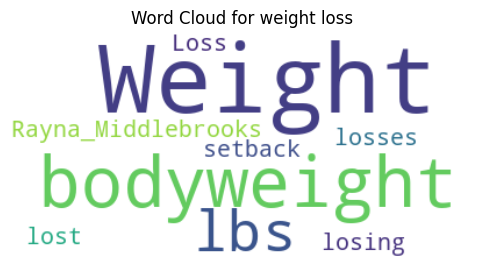

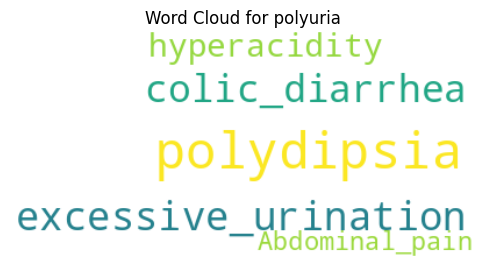

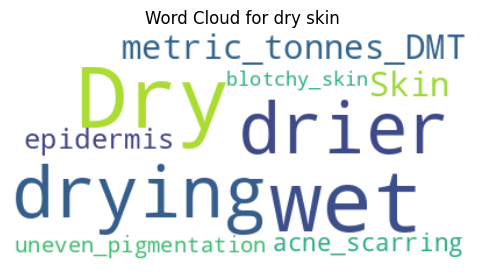

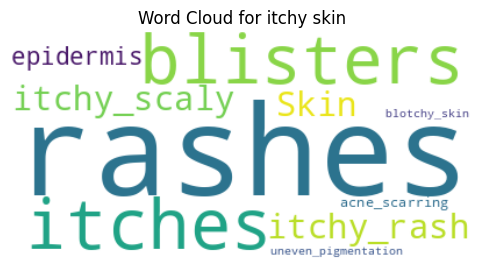

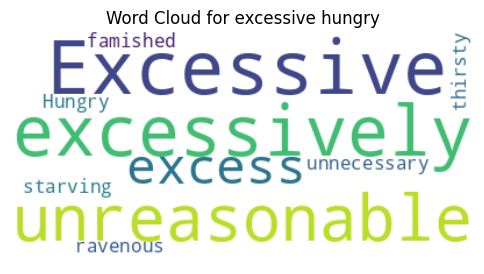

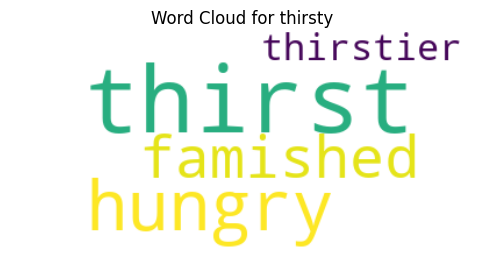

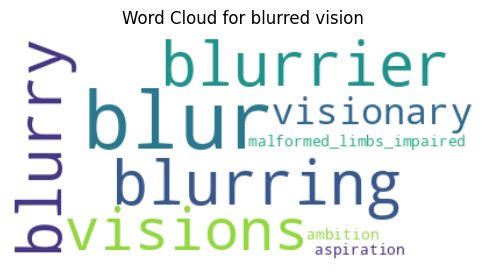

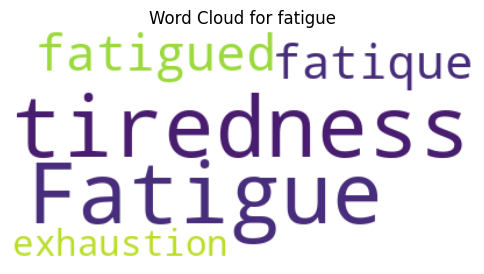

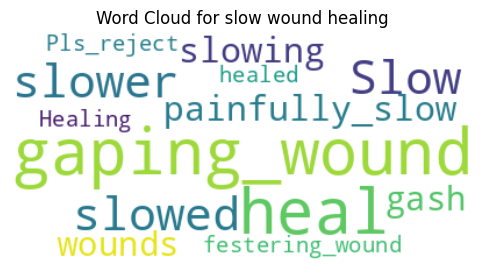

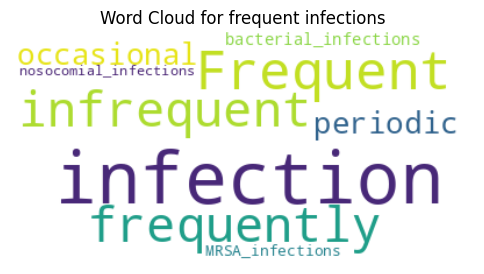

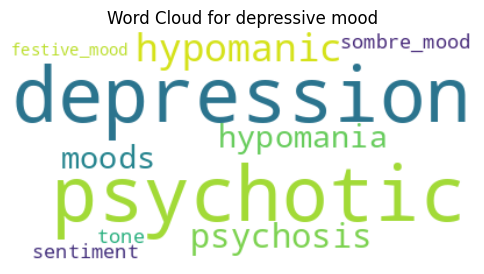

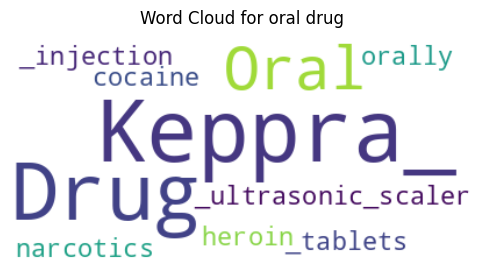

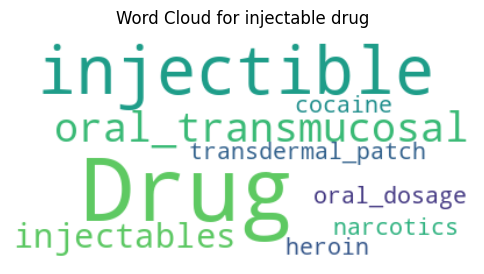

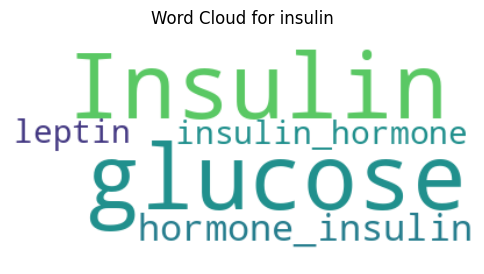

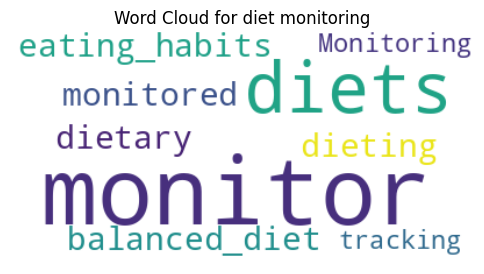

In [ ]:
# Function to generate word cloud
def generate_word_cloud(category_words, category_name):
    words = ' '.join(category_words)
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(words)
    plt.figure(figsize=(6, 4))  # Adjust the figure size for each word cloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {category_name}")
    plt.show()

# Generate word clouds for symptom types
for symptom, similar_words in symptom_similar_words.items():
    generate_word_cloud(similar_words, symptom)

# Generate word clouds for treatment types
for treatment, similar_words in treatment_similar_words.items():
    generate_word_cloud(similar_words, treatment)

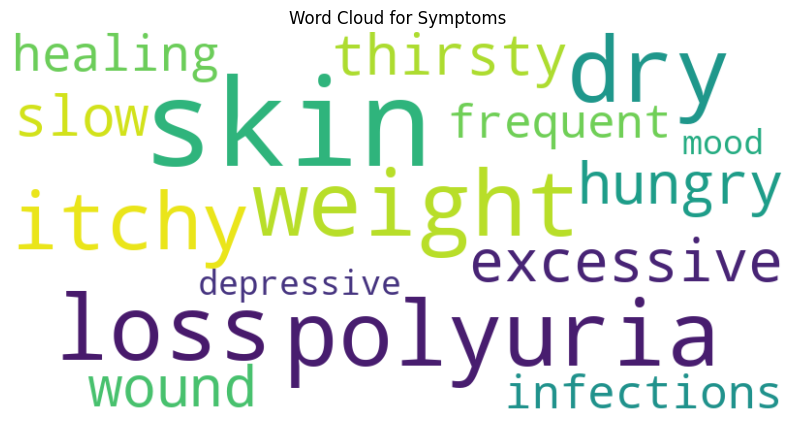

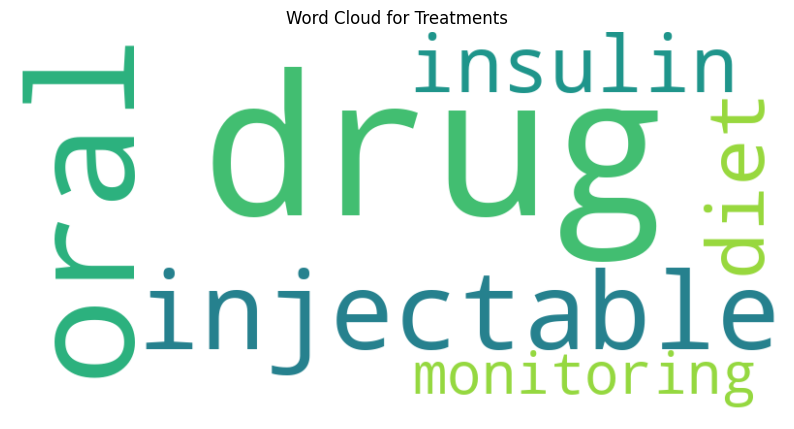

In [ ]:
# Convert symptom and treatment counts to string
symptom_counts_str = ' '.join(symptom_counts.index)
treatment_counts_str = ' '.join(treatment_counts.index)

# Generate word cloud for symptoms
symptom_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(symptom_counts_str)

# Plot the word cloud for symptoms
plt.figure(figsize=(10, 6))
plt.imshow(symptom_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Symptoms')
plt.show()

# Generate word cloud for treatments
treatment_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(treatment_counts_str)

# Plot the word cloud for treatments
plt.figure(figsize=(10, 6))
plt.imshow(treatment_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Treatments')
plt.show()

# Feature Extraction

In [ ]:
# import file
from google.colab import files
uploaded = files.upload()

Saving labelled_data_dropped.csv to labelled_data_dropped.csv


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the preprocessed labeled data
labelled_data = pd.read_csv("labelled_data_dropped.csv")

# Convert the non-null sentences to a list of words
#sentences = [str(sentence).split() for sentence in labelled_data["sentences"]]

# Extract the text columns from the DataFrame
sentences = labelled_data['sentences'].tolist()

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

#applying tf idf to text data
labelled_data_tf = vectorizer.fit_transform(sentences)
#applying tf idf to text data
labelled_data_tf = vectorizer.transform(sentences)
#Let us check the dimensions of the data now.

print("n_samples: %d, n_features: %d" % labelled_data_tf.shape)


n_samples: 3096, n_features: 4584


In [ ]:
# Compute TF-IDF features
tfidf_features = vectorizer.fit_transform(sentences)

# Get the feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Print the words with their frequencies
for i, sent in enumerate(sentences):
    print(f"Sentences {i+1}: {sent}")
    feature_index = tfidf_features[i].nonzero()[1]
    tfidf_scores = zip(feature_index, [tfidf_features[i, x] for x in feature_index])
    for feature_idx, tfidf_score in tfidf_scores:
        feature_name = feature_names[feature_idx]
        print(f"Word: {feature_name}, Frequency: {tfidf_score}")
    print()

Streaming output truncated to the last 5000 lines.
Sentences 2747: attributeslabel expert opinion
Word: opinion, Frequency: 0.714103613410876
Word: expert, Frequency: 0.651774123321894
Word: attributeslabel, Frequency: 0.25543398654350336

Sentences 2748: biobjectiveib use realtim continu glucos monitor rtcgm shown improv glycem control patient type diabet td treat intens insulin therapi
Word: rtcgm, Frequency: 0.3201935578775257
Word: biobjectiveib, Frequency: 0.3624396531009043
Word: realtim, Frequency: 0.3016478491331583
Word: intens, Frequency: 0.3141744429500993
Word: therapi, Frequency: 0.2212092406092086
Word: treat, Frequency: 0.2609525971276487
Word: glycem, Frequency: 0.2072030005418873
Word: shown, Frequency: 0.3016478491331583
Word: monitor, Frequency: 0.2054821843770382
Word: continu, Frequency: 0.21722513988188044
Word: control, Frequency: 0.17951280526546992
Word: use, Frequency: 0.1603774183062908
Word: td, Frequency: 0.1807492384342349
Word: improv, Frequency: 0.207907



---



In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import linear_kernel

# # tfidf calculation
# sent = df_drop
# vector = TfidfVectorizer(#max_df=0.3,         # drop words that occur in more than X percent of documents
#                              #min_df=8,      # only use words that appear at least X times
#                              stop_words='english', # remove stop words
#                              lowercase=True, # Convert everything to lower case
#                              use_idf=True,   # Use idf
#                              norm=u'l2',     # Normalization
#                              smooth_idf=True # Prevents divide-by-zero errors
#                             )
# tfidf = vector.fit_transform(sent)

In [ ]:
# # Initialize the TF-IDF vectorizer
# vectorizer = TfidfVectorizer()

# #applying tf idf to text data
# tf = vectorizer.fit_transform(df_drop)
# #applying tf idf to text data
# tf = vectorizer.transform(df_drop)

In [ ]:
# Remove HTML tags and square brackets
    #abstract = re.sub('<.*?>', '', abstract)
    #abstract = re.sub(r'\[.*?\]', '', abstract)

    # Remove StringElement and attributes
    #abstract = abstract.replace('StringElement', '')
    #abstract = re.sub(r'attributes=\{(.*?)\}', '', abstract)

    # Remove { and }
    #abstract = abstract.replace('{', '').replace('}', '')

In [ ]:
# # Calculate and display counts
# label_data = pd.read_csv("label_data.csv")

# symptom_counts = label_data[symptoms].sum()
# treatment_counts = label_data[treatments].sum()

# print("Symptom counts:")
# print(symptom_counts)

# print("\nTreatment counts:")
# print(treatment_counts)